In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
# Utilities
import re
import os
# Preprocessing
from html import unescape
from fuzzywuzzy import fuzz
# Data management
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [100]:
df = pd.read_csv("./data/book.txt", 
                   sep='\t', 
                   lineterminator='\n', 
                   header=None, 
                   names=["source", "isbn", "title", "authors"])

In [4]:
df.head()

,source,isbn,title,authors
0,eCampus.com,0201853949,"The art Of Computer Programming, Fascicle 3: G...",Not Available\r
1,Indoo.com,0201853949,"Art of Computer Programming, Volume 4, Fascicl...","Knuth, Donald E.\r"
2,textbookxdotcom,0201853949,"The 'art Of Computer Programming, Fascicle 3 G...",\r
3,A1Books,0201853949,"The Art of Computer Programming, Volume 4, Fas...","Knuth, Donald E.\r"
4,textbooksNow,0201853949,Art of Computer Programming,Knuth\r


In [5]:
df.describe()

,source,isbn,title,authors
count,33971,33971,33968,33971
unique,895,1265,11095,9627
top,A1Books,0321263588,Modern Database Management,\r
freq,2403,159,90,713


# Preprocessing

In [6]:
def clean(df, gs=False):
    if gs:
        df["authors"] = df["authors"].str.lower()
        df["authors"] = df["authors"].str.replace('[^\w\s]|\\r','')
        df.authors = df.authors.replace('\s+', ' ', regex=True)
        #df.authors = df.authors.replace(r'\b\w\b', ' ', regex=True)
 
        df['authors'] = df['authors'].str.strip()
    else:
        # Unescape HTML left over from scraping
        df.authors = df.authors.apply(unescape)
        df.title = df.title.apply(lambda x: unescape(str(x)))
        # Lowercase 
        df["authors"] = df["authors"].str.lower()
        df["title"] = df["title"].str.lower()
        df["source"] = df["source"].str.lower()
        # Removes parenthesis from author list
        df["authors"] = df["authors"].str.replace('\((.*?)\)','')
        # Replaces | in author list with spaces
        df["authors"] = df["authors"].str.replace('\|',' ')
        # Special characters removal (removes all special characters left)
        df["title"] = df["title"].str.replace('[^\w\s]|\\r','')
        df["authors"] = df["authors"].str.replace('[^\w\s]|\\r','')
        # Remove numbers from authors
        df['authors'] = df['authors'].str.replace('\d+', '')
        # Uniformize missing values
        df["authors"] = df["authors"].str.replace('not available','')
        df["authors"] = df["authors"].replace(r'^\s*$', np.nan, regex=True)
        # Remove doubled whitespaces
        df.authors = df.authors.replace('\s+', ' ', regex=True)
        df.title = df.title.replace('\s+', ' ', regex=True)
        # Remove trailing spaces
        df.authors = df.authors.str.strip()
        # Remove single characters in authors names
        #df.authors = df.authors.replace(r'\b\w\b', ' ', regex=True)

In [101]:
clean(df)

In [8]:
df.describe()

,source,isbn,title,authors
count,33971,33971,33971,33172
unique,894,1265,7195,6901
top,a1books,0321263588,computer networking and the internet,meyers scott
freq,2403,159,108,136


In [102]:
sum(df.duplicated())

7557

In [103]:
df = df.drop_duplicates()

# Data Quality Metrics

In [11]:
# Unique sources
sources = df.source.unique()

gs = pd.read_csv("./data/book_golden.txt", 
                   sep='\t', 
                   lineterminator='\n', 
                   header=None, 
                   names=["isbn", "authors"])
clean(gs, gs=True)
gs

,isbn,authors
0,9780073516677,oleary timothy j oleary linda i
1,9780072999389,yacht carol crosson susan
2,9780072922363,hutton david v
3,9780072843996,haag stephen perry james t sosinsky barrie est...
4,9780072466850,reddy j n
...,...,...
95,0122290631,eberly david h
96,0120887975,celko joe
97,0120455994,aiken peter allen m david
98,1555581994,cheek matthew


### Completeness
Attribute/Table completeness

NOTE: Closed World assumption

In [130]:
# Null values
null_count = df.isnull().sum()
null_count

source       0
isbn         0
title        0
authors    649
dtype: int64

In [124]:
# Attribute completeness
rows = df.shape[0]
attributes = list(df)
attribute_compl = {}

for attribute in attributes:
    attribute_compl[attribute] = 1 - (null_count[attribute] / rows)

attribute_compl = pd.DataFrame([attribute_compl])
attribute_compl

,source,isbn,title,authors
0,1.0,1.0,1.0,0.97543


In [14]:
# Table completeness
table_compl = 1 - (null_count.sum() / (len(attributes)*rows))
print(table_compl)

0.9938574240932838


### Accuracy (TO SKIP)
Accuracy is computed on the TruthFinder elements
For each source, matching of ISBN and authors list to Golden Standard

In [15]:
def compute_accuracy(source, gs):
    # Computes source accuracy by matching the golden standard rows to the source df, 
    # computing ISBN and Authors accuracy
        
    isbn_match_count = 0
    authors_match_count = 0
    authors_match_percentage = 0
    
    for gs_isbn, gs_authors in zip(gs.isbn, gs.authors):
        select = source[source.isbn == gs_isbn]
        select = select.dropna()
        if not select.empty:
            isbn_match_count += 1
            for authors in select.authors:
                tokens = authors.split()
                gs_tokens = gs_authors.split()
                match = fuzz.token_sort_ratio(tokens, gs_tokens)
                authors_match_percentage += match
                authors_match_count += 1
                
    acc = {
        "isbn": isbn_match_count/len(source.isbn),
        "authors": authors_match_percentage/authors_match_count
    }
    
    return acc

In [16]:
%%script False

source_accuracy = []

if not os.path.exists("./data/results/source_accuracy.csv"):
    for source in sources:
        selected_source = df[df.source == source]
        acc = compute_accuracy(df, gs)
        acc["source"] = source
        source_accuracy.append(acc)
    
    with open('./data/results/source_accuracy.csv', 'w') as f:
        f.write("{}; {}; {}".format("source", 
                                    "isbn coverage", 
                                    "authors accuracy"))
        for e in source_accuracy:
            f.write("{}; {}; {}".format(e["source"], 
                                        e["isbn"], 
                                        e["authors"]))
else:
    source_accuracy = pd.read_csv("./data/results/source_accuracy.csv", 
                   header=["source", "isbn coverage", "authors accuracy"])


Couldn't find program: 'False'


### Coverage
How much data of the dataset each source covers

In [159]:
source_coverage = {}
unique_isbn = len(df.isbn.unique())

if not os.path.exists("./data/results/source_coverage.csv"):
    
    for source in sources:
        selected_source = df[df.source == source]
        source_coverage[source] = len(selected_source.isbn.unique()) / unique_isbn
    with open('./data/results/source_coverage.csv', 'w') as f:
            f.write("{};{}\n".format("source","coverage"))
            for key, value in source_coverage.items():
                f.write("{}; {}\n".format(key, value))
                
else:
    source_coverage = pd.read_csv("data/results/source_coverage.csv", sep=";")

[Text(0, 0, 'schmidsche buchhandlung fachbuch'),
 Text(0, 0, 'oxfam bookshop hertford'),
 Text(0, 0, 'aa42.com'),
 Text(0, 0, 'robinart books'),
 Text(0, 0, 'james & naomi cummings, booksellers'),
 Text(0, 0, 'nancy mcmath'),
 Text(0, 0, 'hein & co. used and rare books'),
 Text(0, 0, 'book gallery // mike riley'),
 Text(0, 0, 'cultured oyster books'),
 Text(0, 0, 'black swan books')]

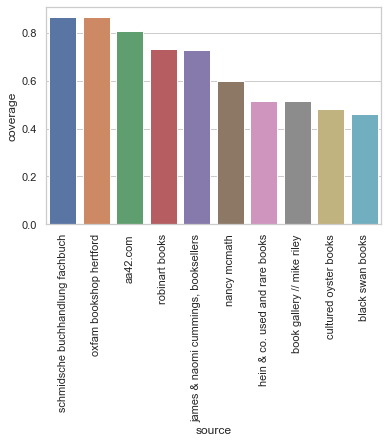

In [185]:
source_coverage = pd.DataFrame(source_coverage)

top_cover = source_coverage.nlargest(10, "coverage")
worst_cover = source_coverage.nsmallest(10, "coverage")

ax = sns.barplot(data=top_cover, x="source", y="coverage")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = sns.barplot(data=worst_cover, x="source", y="coverage")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


In [18]:
# Final cleaning step, drop NaN rows
df = df.dropna()

# Data Fusion

## TruthFinder implementation

In [19]:
%%script False
# TODO: Add cosine similarity with TFIDF vectors

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
tfidf = TfidfVectorizer(min_df=1).fit_transform(df["authors"])

# Finds similarity of first vector compared to every other, see 
# https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity
cosine_similarities = linear_kernel(tfidf[0:1], tfidf).flatten()
related_docs_indices = cosine_similarities.argsort()[:-5:-1]
related_docs_indices

Couldn't find program: 'False'


In [20]:
from truthfinder import TruthFinder

In [21]:
finder = TruthFinder(df.copy(), 
                     fact="authors", 
                     obj="isbn")

result = finder.compute()

In [22]:
# Saving results
result.to_csv("./data/results/truth.csv", index=False)
finder.df.to_csv("./data/results/complete.csv", index=False)

In [27]:
sl = finder.df[finder.df["isbn"] == "0131420445"].sort_values("confidence")
sl

,source,isbn,title,authors,trust,confidence
33308,textbooksnow,0131420445,mips assembly language programming,britton,0.847107,0.782089
33317,sandy chong,0131420445,mips assembly language programming,britton robert l,0.946842,0.927160
33320,englishbookservice.com gti gmbh,0131420445,mips assembly language programming,britton robert l,0.982351,0.927160
33313,textbookxdotcom,0131420445,mips assembly language programming,robert britton,0.874133,0.951676
33315,odeon books,0131420445,mips assembly language programming,robert britton,0.984901,0.951676
33316,papamedia.com,0131420445,mips assembly language programming,robert britton,0.918755,0.951676
33310,indoo.com,0131420445,mips assembly language programming,britton robert,0.936138,0.984816
33311,a1books,0131420445,mips assembly language programming,britton robert,0.949081,0.984816
33312,caiman,0131420445,mips assembly language program,britton robert,0.943724,0.984816
33314,books2anywhere.com,0131420445,mips assembly language programming,britton robert,0.981212,0.984816


In [24]:
sl = finder.df[finder.df["isbn"] == "9780073516677"].sort_values("confidence")
sl[-5:-1]

,source,isbn,title,authors,trust,confidence
17931,textbookxdotcom,9780073516677,computing essentials,oleary timothy j oleary linda i,0.874133,0.99686
17938,revaluation books,9780073516677,computing essentials 2007 complete edition,oleary timothy j oleary linda i,0.956729,0.99686
17922,collegebooksdirect.com,9780073516677,computing essentials,oleary timothy j oleary linda i,0.967471,0.99686
17932,caiman,9780073516677,computing essentials 2007,oleary timothy j oleary linda i,0.943724,0.99686


## TruthFinder Accuracy with respect to the Gold Standard

In [31]:
# Create DF holding the GS authors and TF authors for matching
matching = gs.copy()
matching = matching.rename(columns = {'authors':'authors_gs'})
matching = pd.merge(matching, result, on=['isbn']) # Join
matching = matching.rename(columns = {'authors':'authors_tf'})
matching = matching[["isbn", "authors_gs", "authors_tf"]] # Select

In [32]:
from strsimpy.cosine import Cosine

def similarity(s1, s2):
    cosine = Cosine(2)
    p0 = cosine.get_profile(s1)
    p1 = cosine.get_profile(s2)
    return cosine.similarity_profiles(p0, p1)

tf_accuracy = 0.0

matching['accuracy'] = matching.apply(lambda row: 
                                      similarity(row["authors_gs"], 
                                                 row["authors_tf"]), 
                                      axis = 1)        
tf_accuracy = matching.accuracy.mean()

0.9021033099852027


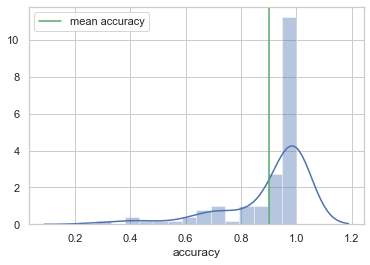

In [64]:
ax = sns.distplot(matching.accuracy);
ax.axvline(tf_accuracy, color='g')
plt.legend({'mean accuracy': tf_accuracy})

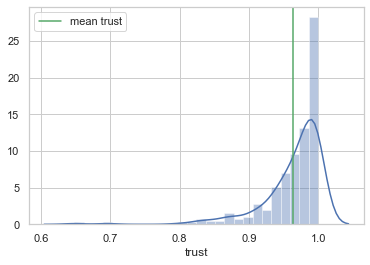

In [65]:
mean_trust = result.drop_duplicates("source").trust.mean()

ax = sns.distplot(result.drop_duplicates("source").trust);
ax.axvline(mean_trust, color='g')
plt.legend({'mean trust': mean_trust})

### Top/Worst 5 matching instances

In [54]:
top5 = matching.nlargest(5,'accuracy')
worst5 = matching.nsmallest(5,'accuracy')

display(top5)
display(worst5)

,isbn,authors_gs,authors_tf,accuracy
2,9780072922363,hutton david v,hutton david v,1.0
32,1558601368,przybylski steven a,przybylski steven a,1.0
40,0750694998,pease robert a,pease robert a,1.0
44,0750656832,pooley rob wilcox pauline,pooley rob wilcox pauline,1.0
58,0321228103,nantz brian,nantz brian,1.0


,isbn,authors_gs,authors_tf,accuracy
14,1558609016,han jiawei kamber micheline,han,0.277350
6,9780072232172,suhanovs dennis,dennis suhanovs press certification certificat...,0.389381
99,1555582745,moore martin hancock steven,moore,0.392232
46,044450673X,jenssen c b kvamdal t andersson h i ecer a per...,jenssen c b,0.451447
36,1555582605,fortier paul j michel howard e,fortierpaul,0.511166


### Top/Worst 10 Sources

In [56]:
top_sources = result.drop_duplicates("source").nlargest(10, "trust")[["source", "trust"]]
worst_sources = result.drop_duplicates("source").nsmallest(10, "trust")[["source", "trust"]]

display(top_sources)
display(worst_sources)

,source,trust
488,spine and crown,1.000000
47,gallowglass books,1.000000
253,reuben goldberg books,1.000000
476,er books,1.000000
257,bigcat books,1.000000
259,a novel idea bookstore,1.000000
49,"gail p. kennon, book-comber",0.999999
11,aa42.com,0.999999
322,chanda's bargain books,0.999998
899,odonnell's general store,0.999997


,source,trust
894,hyannisport books,0.648187
960,valorebooks,0.695493
1166,countless pages book store,0.800402
1026,diane publishing co.,0.823743
167,opoe-abe books,0.826992
20,technischer overseas pvt. ltd.,0.832194
446,recycle bookstore,0.836511
1020,veda's marketing agencies,0.843007
161,textbooksnow,0.847107
501,keen northwest,0.859126


### TruthFinder hyperparameters search

In [72]:
import itertools

dampening = [0.1, 0.3, 0.5]
relatedness = [0.3, 0.5, 0.7]

search_results = []

for param in itertools.product(*[dampening, relatedness]):
    finder = TruthFinder(df.copy(), 
                     fact="authors", 
                     obj="isbn",
                     dampening_factor = param[0],
                     relatedness_factor = param[1])

    result = finder.compute()
    
    matching = gs.copy()
    matching = matching.rename(columns = {'authors':'authors_gs'})
    matching = pd.merge(matching, result, on=['isbn']) # Join
    matching = matching.rename(columns = {'authors':'authors_tf'})
    matching = matching[["isbn", "authors_gs", "authors_tf"]] # Select
    
    matching['accuracy'] = matching.apply(lambda row: 
                                      similarity(row["authors_gs"], 
                                                 row["authors_tf"]), 
                                      axis = 1)        
    accuracy = matching.accuracy.mean()
    search_results.append({"params": param, "accuracy": matching.accuracy.copy()})
    print("Params: {}, Accuracy: {}".format(param, accuracy))

Params: (0.1, 0.3), Accuracy: 0.8963326824632267
Params: (0.1, 0.5), Accuracy: 0.9021033099852027
Params: (0.1, 0.7), Accuracy: 0.9130993198624381
Params: (0.3, 0.3), Accuracy: 0.8963326824632267
Params: (0.3, 0.5), Accuracy: 0.9021033099852027
Params: (0.3, 0.7), Accuracy: 0.9130993198624381
Params: (0.5, 0.3), Accuracy: 0.8963326824632267
Params: (0.5, 0.5), Accuracy: 0.9021033099852027
Params: (0.5, 0.7), Accuracy: 0.9130993198624381


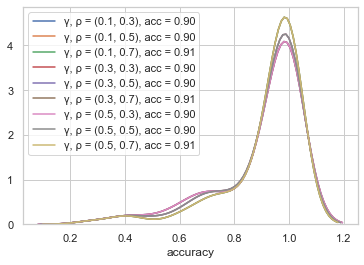

In [97]:
ax = plt.figure()

for res in search_results:
    sns.distplot(res["accuracy"], hist=False, 
                 label = "γ, ρ = {}, acc = {:0.2f}".format(res["params"], res["accuracy"].mean()))
    